In [98]:
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad
from PIL import Image
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

def aes_rsa():
    # AES Encryption
    def encrypt_aes(text, key):
        cipher = AES.new(key, AES.MODE_CBC)
        cipher_text = cipher.encrypt(pad(text.encode(), AES.block_size))
        return cipher_text, cipher.iv

    # RSA Encryption
    def encrypt_rsa(text, public_key):
        cipher_rsa = PKCS1_OAEP.new(public_key)
        cipher_text = cipher_rsa.encrypt(text.encode())
        return cipher_text

    # LSB Embedding
    def embed_LSB(image, data):
        binary_data = ''.join(format(byte, '08b') for byte in data)
        data_index = 0
        img_data = iter(image.flatten())

        for pixel in img_data:
            pixel = format(pixel, '08b')
            pixel = pixel[:-1] + binary_data[data_index]
            image[data_index // 3][data_index % 3] = int(pixel, 2)
            data_index += 1
            if data_index == len(binary_data):
                break

        return image

    # Load Image
    image = cv2.imread('C:\\Users\\ashna\\Downloads\\input_image.png')

    # Text to be encrypted and embedded
    text = 'hello'

    # AES Encryption and Embedding
    aes_key = get_random_bytes(32)  # AES-256 key
    cipher_text_aes, iv_aes = encrypt_aes(text, aes_key)
    # Embed cipher_text_aes into the image using LSB
    image_with_aes = embed_LSB(image.copy(), cipher_text_aes)

    # RSA Encryption and Embedding
    rsa_key = RSA.generate(2048)  # Generate RSA key pair
    public_key = rsa_key.publickey()
    cipher_text_rsa = encrypt_rsa(text, public_key)
    # Embed cipher_text_rsa into the image using LSB
    image_with_rsa = embed_LSB(image.copy(), cipher_text_rsa)

    # Save images
    cv2.imwrite('C:\\Users\\ashna\\Downloads\\aes-output.png', image_with_aes)
    cv2.imwrite('C:\\Users\\ashna\\Downloads\\rsa-output.png', image_with_rsa)

In [99]:
from PIL import Image
import numpy as np
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
import io

def lsb_msb():
    # Function to convert text to bytes
    def text_to_bytes(text):
        return bytes(text, 'utf-8')

    # Function to generate RSA key pair
    def generate_RSA_key():
        key = RSA.generate(2048)
        private_key = key.export_key()
        public_key = key.publickey().export_key()
        return private_key, public_key

    # Function to encrypt data using RSA
    def encrypt_RSA(data, public_key):
        key = RSA.importKey(public_key)
        cipher = PKCS1_OAEP.new(key)
        encrypted_data = cipher.encrypt(data)
        return encrypted_data

    # Function to embed data using LSB
    def embed_LSB(image, data):
        img = Image.open(image).convert('RGBA')
        img_array = np.array(img)

        data_length = len(data)
        data_index = 0

        for row in range(img_array.shape[0]):
            for col in range(img_array.shape[1]):
                for color in range(img_array.shape[2]):
                    if data_index < data_length:
                        img_array[row][col][color] = img_array[row][col][color] & 0xFE | ((data[data_index] >> 7) & 1)
                        data_index += 1
                    else:
                        break
                if data_index >= data_length:
                    break
            if data_index >= data_length:
                break

        embedded_img = Image.fromarray(np.uint8(img_array))
        return embedded_img

    # Function to embed data using MSB
    def embed_MSB(image, data):
        img = Image.open(image).convert('RGBA')
        img_array = np.array(img)

        data_length = len(data)
        data_index = 0

        for row in range(img_array.shape[0]):
            for col in range(img_array.shape[1]):
                for color in range(img_array.shape[2]):
                    if data_index < data_length:
                        img_array[row][col][color] = img_array[row][col][color] & 0x01 | ((data[data_index] >> 7) << 7)
                        data_index += 1
                    else:
                        break
                if data_index >= data_length:
                    break
            if data_index >= data_length:
                break

        embedded_img = Image.fromarray(np.uint8(img_array))
        return embedded_img

    # Data to be embedded
    text_to_embed = 'hello'

    # Generate RSA key pair
    private_key, public_key = generate_RSA_key()

    # Encrypt the data using RSA
    encrypted_data = encrypt_RSA(text_to_bytes(text_to_embed), public_key)

    # Embed encrypted data using LSB
    lsb_embedded_img = embed_LSB('C:\\Users\\ashna\\Downloads\\input_image.png', encrypted_data)
    lsb_embedded_img.save('C:\\Users\\ashna\\Downloads\\lsb-output.png')

    # Embed encrypted data using MSB
    msb_embedded_img = embed_MSB('C:\\Users\\ashna\\Downloads\\input_image.png', encrypted_data)
    msb_embedded_img.save('C:\\Users\\ashna\\Downloads\\msb-output.png')

In [100]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
import os
from skimage import io

def ssim_calculation(img1_path, img2_path):
    # Load the images
    image1 = io.imread(img1_path, as_gray=True)
    image2 = io.imread(img2_path, as_gray=True)

    # Calculate SSIM index with specified data_range (for example, data_range=1 for float images)
    ssim_index = ssim(image1, image2, data_range=image2.max() - image2.min())

    print(f"The SSIM index between the images is: {ssim_index}")
    return ssim_index


def compare_images(img1_path, img2_path):
    # Load images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # Structural Similarity Index (SSIM)
    ssim_index= ssim_calculation(img1_path, img2_path)
    
    # Compression Ratio (CR)
    size_img1 = os.path.getsize(img1_path)
    size_img2 = os.path.getsize(img2_path)
    cr = size_img1 / size_img2
    
    # Correlation Coefficient (CT)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    ct, _ = pearsonr(img1_gray.flatten(), img2_gray.flatten())

    # Structural Similarity Percentage (SP%)
    sp_percent = (1 - ssim_index) * 100
    
    # Bits Per Pixel (BPP)
    bpp = (size_img2 * 8) / (img2.shape[0] * img2.shape[1])
    
    # Mean Squared Error (MSE)
    mse = np.mean((img1.astype("float") - img2.astype("float")) ** 2)
    
    # Peak Signal-to-Noise Ratio (PSNR)
    max_pixel = 255.0
    psnr = 10 * np.log10((max_pixel ** 2) / mse)

    # Bar graph visualization
    metrics = ['SSIM', 'CR', 'CT', 'SP%', 'BPP', 'MSE', 'PSNR']
    values = [ssim_index, cr, ct, sp_percent, bpp, mse, psnr]

    image_to_image_metrics = {metric: value for metric, value in zip(metrics, values)}
    print(image_to_image_metrics)
    return image_to_image_metrics


In [101]:
def result(metrics1, metrics2):

    # Define weights for each metric based on their significance (adjust as needed)
    weights = {
        "SSIM": 0.3,
        "CR": 0.1,
        "CT": 0.1,
        "SP%": 0.1,
        "BPP": 0.05,
        "MSE": 0.2,
        "PSNR": 0.15,
    }

    # Calculate aggregated similarity score for each comparison
    def calculate_similarity_score(metrics):
        total_score = sum(metrics[key] * weights[key] for key in metrics)
        return total_score

    similarity_score_image2 = calculate_similarity_score(metrics1)
    similarity_score_image3 = calculate_similarity_score(metrics2)

    # Compare the similarity scores to determine which image is more similar to Image 1
    if similarity_score_image2 > similarity_score_image3:
        print("Image 2 is more similar to Image 1")
    elif similarity_score_image3 > similarity_score_image2:
        print("Image 3 is more similar to Image 1")
    else:
        print("Both images have similar levels of similarity to Image 1")

    
    #Bar Graph

    # Extracting metric names and values from dictionaries
    metrics = list(metrics1.keys())
    values1 = list(metrics1.values())
    values2 = list(metrics2.values())

    # Plotting the bar chart
    fig, ax = plt.subplots()
    index = range(len(metrics))
    bar_width = 0.35

    bar1 = plt.bar(index, values1, bar_width, label='Metrics 1')
    bar2 = plt.bar([i + bar_width for i in index], values2, bar_width, label='Metrics 2')

    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Comparative Metrics')
    plt.xticks([i + bar_width/2 for i in index], metrics)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [102]:
import matplotlib.pyplot as plt

def result_aes_rsa(metrics1, metrics2):

    # Define the adjusted weights for AES and RSA
    weights_aes = {
        "SSIM": 0.35,
        "CR": 0.1,
        "CT": 0.1,
        "SP%": 0.1,
        "BPP": 0.05,
        "MSE": 0.15,
        "PSNR": 0.15,
    }

    weights_rsa = {
        "SSIM": 0.3,
        "CR": 0.1,
        "CT": 0.1,
        "SP%": 0.1,
        "BPP": 0.05,
        "MSE": 0.2,
        "PSNR": 0.15,
    }

    # Calculate aggregated similarity score for each comparison
    def calculate_similarity_score(metrics, weights):
        total_score = sum(metrics[key] * weights[key] for key in metrics)
        return total_score

    similarity_score_aes = calculate_similarity_score(metrics1, weights_aes)
    similarity_score_rsa = calculate_similarity_score(metrics2, weights_rsa)

    # Compare the similarity scores to determine which image is more similar based on embeddings
    if similarity_score_aes > similarity_score_rsa:
        print("AES embedding is more similar.")
    elif similarity_score_rsa > similarity_score_aes:
        print("RSA embedding is more similar.")
    else:
        print("Both embeddings show similar levels of similarity.")

    # Bar Graph

    # Extracting metric names and values from dictionaries
    metrics = list(metrics1.keys())
    values1 = list(metrics1.values())
    values2 = list(metrics2.values())

    # Plotting the bar chart
    fig, ax = plt.subplots()
    index = range(len(metrics))
    bar_width = 0.35

    bar1 = plt.bar(index, values1, bar_width, label='AES Embedding')
    bar2 = plt.bar([i + bar_width for i in index], values2, bar_width, label='RSA Embedding')

    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Comparative Metrics')
    plt.xticks([i + bar_width / 2 for i in index], metrics)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [103]:
def caller_function():
    aes_rsa()
    lsb_msb()

def analysis_caller(img1_path, img2_path, img3_path):
    metrics1=compare_images(img1_path, img2_path)
    metrics2=compare_images(img1_path, img3_path)
    result(metrics1, metrics2)

def analysis_caller_aes_rsa(img1_path, img2_path, img3_path):
    metrics1=compare_images(img1_path, img2_path)
    metrics2=compare_images(img1_path, img3_path)
    result_aes_rsa(metrics1, metrics2)

In [104]:
caller_function()

c:\Users\ashna\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


The SSIM index between the images is: 0.9999430117126946
{'SSIM': 0.9999430117126946, 'CR': 0.29984063323013815, 'CT': 0.9999859281331467, 'SP%': 0.005698828730538175, 'BPP': 1.0213267112509834, 'MSE': 0.053396275898242855, 'PSNR': 60.855693924768595}
The SSIM index between the images is: 0.9999430117126946
{'SSIM': 0.9999430117126946, 'CR': 0.29984063323013815, 'CT': 0.9999859281331467, 'SP%': 0.005698828730538175, 'BPP': 1.0213267112509834, 'MSE': 0.053396275898242855, 'PSNR': 60.855693924768595}
AES embedding is more similar.


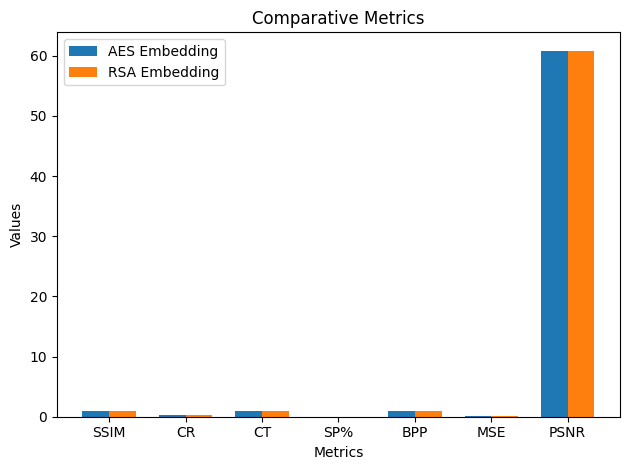

In [105]:
analysis_caller_aes_rsa('C:\\Users\\ashna\\Downloads\\input_image.png', 'C:\\Users\\ashna\\Downloads\\aes-output.png','C:\\Users\\ashna\\Downloads\\rsa-output.png')

c:\Users\ashna\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


The SSIM index between the images is: 0.6995869870359965
{'SSIM': 0.6995869870359965, 'CR': 0.377911281024334, 'CT': 0.9999999949288672, 'SP%': 30.04130129640035, 'BPP': 0.8103363493312352, 'MSE': 2.028422501966955e-05, 'PSNR': 95.059219411919}
The SSIM index between the images is: 0.6995633485518062
{'SSIM': 0.6995633485518062, 'CR': 0.37810631128381045, 'CT': 0.9999473661891878, 'SP%': 30.043665144819375, 'BPP': 0.809918371361133, 'MSE': 0.2003147128245476, 'PSNR': 55.11367512104282}
Image 2 is more similar to Image 1


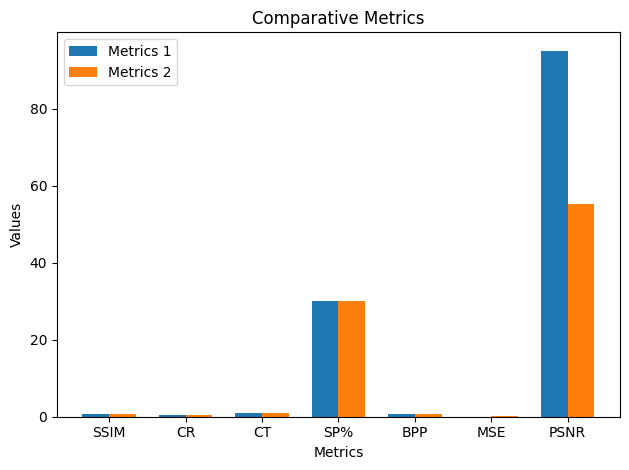

In [106]:
analysis_caller('C:\\Users\\ashna\\Downloads\\input_image.png', 'C:\\Users\\ashna\\Downloads\\lsb-output.png','C:\\Users\\ashna\\Downloads\\msb-output.png')